In [1]:
import numpy as np
import csv
from tqdm import tqdm
import base64
from io import BytesIO
import requests
import io
import pandas as pd
import os

In [4]:
# Username of your GitHub account
username = ''

# Personal Access Token (PAO) from your GitHub account
token = ''

# Creates a re-usable session object with your creds in-built
github_session = requests.Session()
github_session.auth = (username, token)


In [5]:
url = 'https://raw.githubusercontent.com/OmdenaAI/WeoWater/main/task-3-wrangling-preprocessing/All_merged/All_data_sources_merged_updated.csv'
download = github_session.get(url).content #Reading and downloading the data
data = pd.read_csv(io.StringIO(download.decode('utf-8'))) #Converting the data into a pd dataframe

#Extract instagram data from all dataseources
ig_data = data.loc[data['data source']=='Instagram']
ig_data.to_csv('ig_data.csv')

In [6]:
ig_data = pd.read_csv('ig_data.csv') 

In [7]:
ig_data.head(10)

,Unnamed: 0,Id,title,time,keywords,data source,category,country,source URL,body,language
0,4216,1.790000e+16,NaN,2021-06-17T14:49:15+0000,NaN,Instagram,none,NaN,https://www.instagram.com/p/CQOakCZHpB2/,“Absence the highest form of presence”. #absen...,English
1,4217,1.790000e+16,NaN,2021-06-01T20:45:52+0000,NaN,Instagram,none,NaN,https://www.instagram.com/p/CPl2p5LBGVa/,Hearing aid design has come a very long way. W...,English
2,4218,1.790000e+16,NaN,2021-06-01T19:30:47+0000,NaN,Instagram,none,NaN,https://www.instagram.com/p/CPluDpMNFss/,Happy #PrideMonth from BAHA Irish Whiskey. Be ...,English
3,4219,1.790000e+16,NaN,2021-06-01T19:05:43+0000,NaN,Instagram,none,NaN,https://www.instagram.com/p/CPlrHFjgNKf/,Figuring out these crazy hands 😆\n\n#babiesofi...,English
4,4220,1.790000e+16,NaN,2021-06-01T18:24:14+0000,NaN,Instagram,none,NaN,https://www.instagram.com/p/CPlmch8HzKT/,I am THRILLED to share these pictures with you...,English
5,4221,1.800000e+16,NaN,2021-06-01T16:29:29+0000,NaN,Instagram,none,NaN,https://www.instagram.com/p/CPlZUKzJ2kR/,Did you know that people with Down syndrome te...,English
6,4222,1.790000e+16,NaN,2021-06-01T16:03:37+0000,NaN,Instagram,none,NaN,https://www.instagram.com/p/CPlWWuEHmbI/,Beautiful Day 25°c. Feels great to be back at ...,English
7,4223,1.790000e+16,NaN,2021-06-01T14:44:53+0000,NaN,Instagram,none,NaN,https://www.instagram.com/p/CPlNWCgAZUk/,FOLLOW OUR PAGE - santal_insta_model \n.\n.\nU...,English
8,4224,1.790000e+16,NaN,2021-06-01T13:54:59+0000,NaN,Instagram,none,NaN,https://www.instagram.com/p/CPlG8c2j_6E/,7’10” 2 piece 70/30 split is all done and read...,English
9,4225,1.810000e+16,NaN,2021-06-01T13:11:11+0000,NaN,Instagram,none,NaN,https://www.instagram.com/p/CPlCnzNCoy1/,The Battle Pass is back in the game! Colossal ...,English


In [8]:
ig_data.shape

(1633, 11)

In [9]:
ig_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1633 entries, 0 to 1632
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Unnamed: 0   1633 non-null   int64  
 1   Id           1633 non-null   float64
 2   title        0 non-null      float64
 3   time         1609 non-null   object 
 4   keywords     0 non-null      float64
 5   data source  1633 non-null   object 
 6   category     1633 non-null   object 
 7   country      0 non-null      float64
 8   source URL   1633 non-null   object 
 9   body         1633 non-null   object 
 10  language     1633 non-null   object 
dtypes: float64(4), int64(1), object(6)
memory usage: 140.5+ KB


In [10]:
drop_columns = ['Unnamed: 0','title', 'time', 'keywords', 'data source', 'country', 'source URL', 'language', 'Id']
ig_data_clean = ig_data.drop(columns=drop_columns,axis=1)

In [11]:
ig_data_clean

,category,body
0,none,“Absence the highest form of presence”. #absen...
1,none,Hearing aid design has come a very long way. W...
2,none,Happy #PrideMonth from BAHA Irish Whiskey. Be ...
3,none,Figuring out these crazy hands 😆\n\n#babiesofi...
4,none,I am THRILLED to share these pictures with you...
...,...,...
1628,none,this pile is giving an impression how high wat...
1629,flood,Long weekend vibes \nAs you can see we had lot...
1630,none,On a bench at high watermark - learning in pro...
1631,flood,#letzebuerg #luxembourg #luxembourgcity #diffe...


In [12]:
ig_data_clean.reset_index(drop=True,inplace=True)

In [13]:
ig_data_clean['body'].duplicated().sum()

0

**NLP Model**

In [14]:
!pip install chart-studio

     |████████████████████████████████| 71kB 9.8MB/s 


In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D,Bidirectional
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.layers import Dropout
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize,RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem.porter import *
from nltk import word_tokenize
STOPWORDS = set(stopwords.words('english'))
from bs4 import BeautifulSoup
import plotly.graph_objs as go
from chart_studio import plotly
from sklearn.utils import shuffle
import cufflinks
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from IPython.core.interactiveshell import InteractiveShell
import plotly.figure_factory as ff
InteractiveShell.ast_node_interactivity = 'all'
from plotly.offline import iplot
cufflinks.go_offline()
cufflinks.set_config_file(world_readable=True, theme='pearl')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [16]:
#Clean the tweet text using nltk corpus and stopwords
clean_tweets=[]
for posts in tqdm(ig_data_clean['body']):
  tokenizer= RegexpTokenizer(r'\w+')
  token_words= tokenizer.tokenize(posts)
  token_with_stopword= [word for word in token_words if not word in stopwords.words()]
  clean_tweets.append(token_with_stopword)

100%|██████████| 1633/1633 [04:51<00:00,  5.60it/s]


In [17]:
ig_data_clean['Cleaned_body']= clean_tweets

In [18]:
ig_data_clean

,category,body,Cleaned_body
0,none,“Absence the highest form of presence”. #absen...,"[Absence, highest, form, presence, absence, pr..."
1,none,Hearing aid design has come a very long way. W...,"[Hearing, aid, design, long, way, With, sleek,..."
2,none,Happy #PrideMonth from BAHA Irish Whiskey. Be ...,"[Happy, PrideMonth, BAHA, Irish, Whiskey, Be, ..."
3,none,Figuring out these crazy hands 😆\n\n#babiesofi...,"[Figuring, crazy, hands, babiesofinstagram, ba..."
4,none,I am THRILLED to share these pictures with you...,"[I, THRILLED, share, pictures, This, Rachel, C..."
...,...,...,...
1628,none,this pile is giving an impression how high wat...,"[pile, giving, impression, high, water, level,..."
1629,flood,Long weekend vibes \nAs you can see we had lot...,"[Long, weekend, vibes, As, see, lots, rain, re..."
1630,none,On a bench at high watermark - learning in pro...,"[On, bench, high, watermark, learning, progres..."
1631,flood,#letzebuerg #luxembourg #luxembourgcity #diffe...,"[letzebuerg, luxembourg, luxembourgcity, diffe..."


**Class Imbalance for category column**

In [19]:
ig_data_clean.category.value_counts()

none       1138
flood       388
drought     107
Name: category, dtype: int64

In [20]:
ig_data_drought = ig_data_clean[ig_data_clean.category == 'drought']
ig_data_drought.shape

(107, 3)

In [21]:
ig_data_flood = ig_data_clean[ig_data_clean.category == 'flood']
ig_data_flood.shape

(388, 3)

In [22]:
ig_data_none = ig_data_clean[ig_data_clean.category == 'none']
ig_data_none.shape

(1138, 3)

In [23]:
df_drought = shuffle(ig_data_drought)
df_flood = shuffle(ig_data_flood)
df_none = shuffle(ig_data_none)

In [24]:
ig_train_d= df_drought.head(100)
ig_train_d.shape

(100, 3)

In [25]:
ig_train_f= df_flood.head(340)
ig_train_f.shape

(340, 3)

In [26]:
ig_train_n= df_none.head(340)
ig_train_n.shape

(340, 3)

In [27]:
ig_test_d= df_drought.tail(8)
ig_test_d.shape

(8, 3)

In [28]:
ig_test_f= df_flood.tail(48)
ig_test_f.shape

(48, 3)

In [29]:
ig_test_n= df_none.tail(48)
ig_test_n.shape

(48, 3)

In [30]:
#concatenating
ig_train =pd.concat([ig_train_d,ig_train_f,ig_train_n], ignore_index=True)
ig_train = shuffle(ig_train)
ig_train.shape

(780, 3)

In [31]:
ig_train.category.value_counts()

none       340
flood      340
drought    100
Name: category, dtype: int64

In [32]:
#concatenating
ig_test =pd.concat([ig_test_d,ig_test_f,ig_test_n], ignore_index=True)
ig_test = shuffle(ig_test)
ig_test.shape

(104, 3)

In [33]:
#changing the type from object to category
ig_train['category']=ig_train['category'].astype('category')
ig_test['category']=ig_test['category'].astype('category')

In [34]:
# Get the numerical ids of column label
numerical_ids_train = ig_train.category.cat.codes
numerical_ids_test = ig_test.category.cat.codes

# Print initial shape
print(numerical_ids_train.shape)
print(numerical_ids_test.shape)

(780,)
(104,)


In [35]:
# One-hot encode the indexes
Y = to_categorical(numerical_ids_train)
Y_test = to_categorical(numerical_ids_test)

# Check the new shape of the variable
print(Y.shape)
print(Y_test.shape)

# Print the first 5 rows
print(Y[:5])

(780, 3)
(104, 3)
[[0. 0. 1.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [1. 0. 0.]]


In [36]:
ig_train['category'] = ig_train['category'].replace({'flood':1,'drought':2,'none':3})

In [37]:
ig_test['category'] = ig_test['category'].replace({'flood':1,'drought':2,'none':3})

In [38]:
ig_train

,category,body,Cleaned_body
538,3,#fyp#awsome #war\n#argentina #photo\n#picofthe...,"[fyp, awsome, argentina, photo, picoftheday, f..."
41,2,We didn’t make it through this hike. The old m...,"[We, make, hike, The, old, mostly, direct, sun..."
351,1,Flash floods in Nepal's Sindhupalchol has clai...,"[Flash, floods, Nepal, Sindhupalchol, claimed,..."
424,1,#vacation #island #picoftheday #beachlife#lov...,"[vacation, island, picoftheday, beachlife, lov..."
77,2,Can’t get enough of this water. #drought #wate...,"[Can, get, enough, water, drought, waterinthed..."
...,...,...,...
249,1,A red-alert level deluge is swamping the Cante...,"[A, red, alert, level, deluge, swamping, Cante..."
608,3,What happens when water gets into a sealed reg...,"[What, happens, water, gets, sealed, regulator..."
123,1,Mom's Life 😍\n\nIch zeige dir die Welt und noc...,"[Mom, Life, Ich, zeige, Welt, mehr, Unser, ers..."
428,1,Flood #flood #flashflood #rain #rainyday #summ...,"[Flood, flood, flashflood, rain, rainyday, sum..."


In [39]:
ig_test

,category,body,Cleaned_body
41,1,"We had a Flash Flood yesterday. Thankfully, al...","[We, Flash, Flood, yesterday, Thankfully, crit..."
10,1,BLEEDING HEART EP ONNA WAY ND YEAH FUCC ALL U ...,"[BLEEDING, HEART, EP, ONNA, WAY, ND, YEAH, FUC..."
21,1,Fair to say we copped a bit of rain at the far...,"[Fair, say, copped, bit, rain, farm, today, an..."
57,3,Everybody wants to hit the pool and beat the h...,"[Everybody, wants, hit, pool, beat, heat, summ..."
49,1,~Aftermath~Flashflood~Helambu~\n#aftermath #fl...,"[Aftermath, Flashflood, Helambu, aftermath, fl..."
...,...,...,...
36,1,*When you take the Jeep Wave too seriously 🌊 😂...,"[When, Jeep, Wave, seriously, No, still, car, ..."
77,3,'The Flood'\n.\n.\n.\n#colouredpencildrawing #...,"[The, Flood, colouredpencildrawing, zestitpenc..."
102,3,Figuring out these crazy hands 😆\n\n#babiesofi...,"[Figuring, crazy, hands, babiesofinstagram, ba..."
92,3,In Genesis God tells us that he created the ra...,"[In, Genesis, God, tells, us, created, rainbow..."


**fit_on_texts:** Updates internal vocabulary based on a list of texts. This method creates the vocabulary index based on word frequency. So if you give it something like, "The cat sat on the mat." It will create a dictionary s.t. word_index["the"] = 1; word_index["cat"] = 2 it is word -> index dictionary so every word gets a unique integer value. 0 is reserved for padding. So lower integer means more frequent word (often the first few are stop words because they appear a lot).


**texts_to_sequences:** Transforms each text in texts to a sequence of integers. So it basically takes each word in the text and replaces it with its corresponding integer value from the word_index dictionary. Nothing more, nothing less, certainly no magic involved.

In [40]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(ig_train.Cleaned_body)
# Create the (X, Y) variables
X = tokenizer.texts_to_sequences(ig_train.Cleaned_body)
X = pad_sequences(X, maxlen=20)
#Y = to_categorical(ig_train.category)
# Print the shapes
print(X.shape)
print(Y.shape)

(780, 20)
(780, 3)


In [41]:
X_test = tokenizer.texts_to_sequences(ig_test.Cleaned_body)
X_test = pad_sequences(X_test, maxlen=20)
#Y_test = to_categorical(ig_test.category)
print(X_test.shape)
print(Y_test.shape)

(104, 20)
(104, 3)


In [42]:
# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 30000


EMBEDDING_DIM = 100

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 11681 unique tokens.


In [43]:
from keras.optimizers import SGD,Adam
opt = SGD(learning_rate=0.01)
opt1= Adam() 

**Spatial 1D:** it drops entire 1D feature maps instead of individual elements. If adjacent frames within feature maps are strongly correlated (as is normally the case in early convolution layers) then regular dropout will not regularize the activations and will otherwise just result in an effective learning rate decrease.

1. Dropout(): Let's define 2D input: [[1, 1, 1], [2, 2, 2]]. Dropout will consider every element independently, and may result in something like [[1, 0, 1], [0, 2, 2]]

2. SpatialDropout1D(): In this case result will look like [[1, 0, 1], [2, 0, 2]]. Notice that 2nd element was zeroed along all channels.

In [44]:
model= Sequential()
model.add(Embedding(MAX_NB_WORDS,EMBEDDING_DIM,input_length=X.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(1300,dropout=0,recurrent_dropout=0))
model.add(Dense(1200,activation='relu'))
model.add(Dense(1024,activation='relu'))
model.add(Dense(720,activation='relu'))
model.add(Dense(320,activation='relu'))
model.add(Dense(96,activation='relu'))
model.add(Dense(48,activation='relu'))
model.add(Dense(16,activation='relu'))
model.add(Dense(3,activation='softmax'))
model.compile(optimizer='adam',loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 20, 100)           3000000   
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 20, 100)           0         
_________________________________________________________________
lstm (LSTM)                  (None, 1300)              7285200   
_________________________________________________________________
dense (Dense)                (None, 1200)              1561200   
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              1229824   
_________________________________________________________________
dense_2 (Dense)              (None, 720)               738000    
_________________________________________________________________
dense_3 (Dense)              (None, 320)               2

In [45]:
epochs= 40
batch_size= 300

history= model.fit(X,Y,epochs=epochs,batch_size=batch_size,validation_split=0.1)

Epoch 1/40
3/3 [==============================] - 23s 531ms/step - loss: 1.0938 - accuracy: 0.4243 - val_loss: 1.0278 - val_accuracy: 0.3333
Epoch 2/40
3/3 [==============================] - 0s 115ms/step - loss: 1.0344 - accuracy: 0.4395 - val_loss: 0.9447 - val_accuracy: 0.3333
Epoch 3/40
3/3 [==============================] - 0s 92ms/step - loss: 0.9812 - accuracy: 0.4495 - val_loss: 0.9139 - val_accuracy: 0.5769
Epoch 4/40
3/3 [==============================] - 0s 91ms/step - loss: 0.9272 - accuracy: 0.4218 - val_loss: 1.0353 - val_accuracy: 0.3333
Epoch 5/40
3/3 [==============================] - 0s 95ms/step - loss: 0.8750 - accuracy: 0.4075 - val_loss: 0.8152 - val_accuracy: 0.6410
Epoch 6/40
3/3 [==============================] - 0s 92ms/step - loss: 0.8021 - accuracy: 0.4353 - val_loss: 0.8603 - val_accuracy: 0.6923
Epoch 7/40
3/3 [==============================] - 0s 94ms/step - loss: 0.7590 - accuracy: 0.5013 - val_loss: 0.9864 - val_accuracy: 0.3333
Epoch 8/40
3/3 [========

Text(0.5, 1.0, 'Loss')

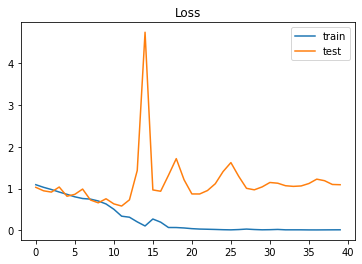

In [46]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

Text(0.5, 1.0, 'Accuracy')

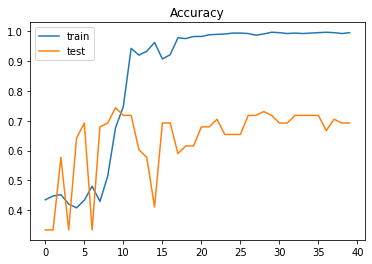

In [47]:
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show()

**Predicting Data**

In [48]:
y_pred = model.predict(X_test)

In [49]:
import numpy as np
y_pred=np.round(y_pred)

In [50]:
y_pred = np.argmax(y_pred, axis=-1)

In [51]:
y_test = np.argmax(Y_test, axis=-1)

In [52]:
y_pred

array([1, 1, 1, 2, 1, 0, 1, 1, 0, 0, 2, 1, 2, 1, 1, 1, 0, 1, 1, 1, 1, 1,
       2, 1, 1, 1, 1, 0, 1, 2, 0, 1, 2, 2, 1, 1, 2, 1, 1, 2, 1, 0, 1, 1,
       1, 2, 2, 2, 1, 1, 1, 0, 0, 0, 1, 2, 0, 1, 1, 1, 1, 2, 1, 1, 1, 1,
       1, 1, 2, 0, 1, 2, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1,
       2, 2, 1, 0, 2, 1, 1, 1, 2, 1, 1, 1, 1, 2, 2, 2])

In [53]:
# Accuracy
print(accuracy_score(y_test, y_pred))

0.7115384615384616


In [54]:
print(precision_score(y_test, y_pred, average=None))
print(recall_score(y_test, y_pred, average=None))
print(f1_score(y_test, y_pred, average=None))

[0.46666667 0.703125   0.88      ]
[0.875      0.9375     0.45833333]
[0.60869565 0.80357143 0.60273973]


In [55]:
lab_names = ['flood','drought','none']
print(classification_report(y_test, y_pred, target_names=lab_names))

              precision    recall  f1-score   support

       flood       0.47      0.88      0.61         8
     drought       0.70      0.94      0.80        48
        none       0.88      0.46      0.60        48

    accuracy                           0.71       104
   macro avg       0.68      0.76      0.67       104
weighted avg       0.77      0.71      0.70       104



In [56]:
# Get probabilities for each class
pred_probabilities = model.predict(X_test)
DEFAULT_CLASS = 1
# Thresholds at 0.5 and 0.8
y_pred_50 = [np.argmax(x) if np.max(x) >= 0.5 else DEFAULT_CLASS for x in pred_probabilities]
y_pred_80 = [np.argmax(x) if np.max(x) >= 0.8 else DEFAULT_CLASS for x in pred_probabilities]

trade_off = pd.DataFrame({
    'Precision_50': precision_score(y_test, y_pred_50, average=None), 
    'Precision_80': precision_score(y_test, y_pred_80, average=None), 
    'Recall_50': recall_score(y_test, y_pred_50, average=None), 
    'Recall_80': recall_score(y_test, y_pred_80, average=None)}, 
  index=['flood','drought','none'])

print(trade_off)

         Precision_50  Precision_80  Recall_50  Recall_80
flood        0.500000      0.416667   0.875000   0.625000
drought      0.692308      0.652174   0.937500   0.937500
none         0.880000      0.869565   0.458333   0.416667


In [57]:
# Build the confusion matrix
confusion_matrix(y_test, y_pred_50)

array([[ 7,  1,  0],
       [ 0, 45,  3],
       [ 7, 19, 22]])

In [58]:
# Build the confusion matrix
confusion_matrix(y_test, y_pred_80)

array([[ 5,  3,  0],
       [ 0, 45,  3],
       [ 7, 21, 20]])

In [59]:
# Build the confusion matrix
confusion_matrix(y_test, y_pred)

array([[ 7,  1,  0],
       [ 0, 45,  3],
       [ 8, 18, 22]])

In [61]:
model.save('Multi_Text_LSTMClassifier_with_ig.h5')